# 05 Crash course on Neural Nets

## Skip this lecture if you think you are a Deep Learning master

#### 👉 Let's train a few neural network models in a supervised setting.

#### 👉 In Supervised Machine Learning you have input features and target values. And the goal is to find the *right* mapping between input features and target values.

#### 👉Neural networks are usually highly-parametric models that are able to fit complex patterns between the input features and the target.

#### 👉 The type of neural network we will use is a Multi Layer Perceptron (MLP). MLPs are stacks of linear models, interleaved with *activation functions.*

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

In [2]:
import gym
from tqdm import tqdm
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

# 1. Data

Steps to generate the train data and test data we will need to build the neural network, and to evaluate it.

## 1.1 Download the agent parameters from Google Drive 📩

In [3]:
from supervised_ml import download_agent_parameters

path_to_agent_data = download_agent_parameters()
print(f'path_to_agent_data={path_to_agent_data}')

Downloading...
From: https://docs.google.com/uc?export=download&id=1ZdyAuzY-0VYfyNrg0a7gHd5TOX-GadJJ
To: C:\Users\Ploita\Documents\GitHub\hands-on-rl\03_cart_pole\saved_agents\CartPole-v1\gdrive_agent.zip
100%|██████████| 255k/255k [00:00<00:00, 1.05MB/s]

path_to_agent_data=C:\Users\Ploita\Documents\GitHub\hands-on-rl\03_cart_pole\saved_agents\CartPole-v1\298


## 1.2 Create `QAgent` object from the parameters (and hyper-parameters) we just downloaded

In [4]:
from q_agent import QAgent

agent = QAgent.load_from_disk(env, path=path_to_agent_data)

67,586 parameters


## 1.3 Let's check it works like a charm

In [5]:
from utils import set_seed
set_seed(env, 1234)

from loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.0 # 100% greedy strategy
)

100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]


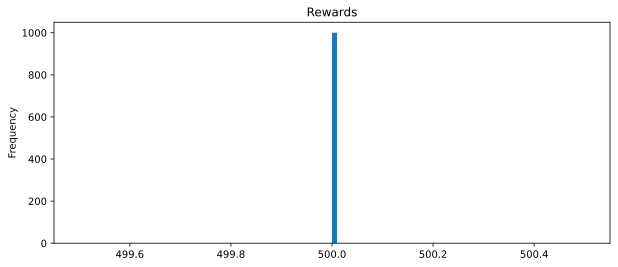

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## 1.4 Generate train data -->  `train.csv`

In [7]:
from supervised_ml import generate_state_action_data
from config import DATA_SUPERVISED_ML

n_samples_train = 1000
path_to_train_data = DATA_SUPERVISED_ML / 'train.csv'


# we let the agent interact with the environment until we have
# collected enough pairs (state, action)
generate_state_action_data(env, agent,
                           n_samples=n_samples_train,
                           path=path_to_train_data)

100%|██████████| 1000/1000 [00:00<00:00, 3366.08it/s]


## 1.5 Generate test data --> `test.csv`

In [8]:
# test data
n_samples_test = 1000
path_to_test_data = DATA_SUPERVISED_ML / 'test.csv'

# Very important to use another seed than for the
# train set

generate_state_action_data(env, agent, 
                           n_samples=n_samples_test,
                           path=path_to_test_data)

100%|██████████| 1000/1000 [00:00<00:00, 3660.53it/s]


-----

# 2. Let's train a few neural networks

#### 👉We will try different neural network architecture, to see which one works best for our problem.
#### 👉 Finding the right architecture is not an easy problem. This is one of the hard parts of training neural networks.

## Load `train.csv` and `test.csv` into 🐼

In [9]:
import pandas as pd

train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)

## PyTorch datasets

In [10]:
from torch.utils.data import Dataset

class OptimalPolicyDataset(Dataset):

    def __init__(self, X: pd.DataFrame, y: pd.Series):
        self.X = X
        self.y = y

    def __len__(self):
        """
        Returns number of samples in the data
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns the features and label
        of sample number `idx`
        """
        return self.X.iloc[idx].values, self.y.iloc[idx]

In [11]:
# split features and labels
X_train = train_data[['s0', 's1', 's2', 's3']]
y_train = train_data['action']
X_test = test_data[['s0', 's1', 's2', 's3']]
y_test = test_data['action']

# PyTorch datasets
from supervised_ml import OptimalPolicyDataset
train_dataset = OptimalPolicyDataset(X_train, y_train)
test_dataset = OptimalPolicyDataset(X_test, y_test)

## PyTorch dataloaders

In [12]:
BATCH_SIZE = 64

# PyTorch dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

## Loss function
#### 👉 The cross entropy is a common choice for classification problems

In [13]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

## Model 0: Baseline

In [14]:
train_data['action'].value_counts()

action
1    500
0    500
Name: count, dtype: int64

In [15]:
test_data['action'].value_counts()

action
1    501
0    499
Name: count, dtype: int64

## Model 1: Linear model

### Model architecture 📐🏗️

In [16]:
import torch
from model_factory import get_model, count_parameters

# linear model --> no hidden_layers (hidden_layers = None)
model = get_model(input_dim=4, output_dim=2, hidden_layers=None)

# send the model to GPU if you have one.
# GPUs have a very fast implementation of matrix multiplication,
# which is the key operation to propagate inputs to outputs
# in most neural network architectures
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

10 parameters
Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/linear_model_sml.jpg?raw=true)

### Train loop 🏋️

In [17]:
# Tensorboard logger
import time
from supervised_ml import get_tensorboard_writer
run_name = f'linear/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

# train_val_loop runs a full pass on the given data
# (either train or test) and logs metrics to tensorboard
from supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model,
                                    criterion,
                                    optimizer,
                                    tensorboard_writer)


# call train_val_loop 150 times for training,
# and 150 times for evaluating.
N_EPOCHS = 150
for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True,
                   dataloader=train_dataloader,
                   epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False,
                       dataloader=test_dataloader,
                       epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.6390 - accuracy: 0.6790: 100%|██████████| 16/16 [00:00<00:00, 123.69it/s]


----------


Epoch 1 - loss: 0.6356 - accuracy: 0.6930: 100%|██████████| 16/16 [00:00<00:00, 107.33it/s]


----------


Epoch 2 - loss: 0.6326 - accuracy: 0.6930: 100%|██████████| 16/16 [00:00<00:00, 115.53it/s]


----------


Epoch 3 - loss: 0.6296 - accuracy: 0.6940: 100%|██████████| 16/16 [00:00<00:00, 133.90it/s]


----------


Epoch 4 - loss: 0.6268 - accuracy: 0.6980: 100%|██████████| 16/16 [00:00<00:00, 123.11it/s]


----------


Epoch 5 - loss: 0.6242 - accuracy: 0.7010: 100%|██████████| 16/16 [00:00<00:00, 136.95it/s]


----------


Epoch 6 - loss: 0.6217 - accuracy: 0.7020: 100%|██████████| 16/16 [00:00<00:00, 143.21it/s]


----------


Epoch 7 - loss: 0.6193 - accuracy: 0.7030: 100%|██████████| 16/16 [00:00<00:00, 150.24it/s]


----------


Epoch 8 - loss: 0.6171 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 161.76it/s]


----------


Epoch 9 - loss: 0.6148 - accuracy: 0.7020: 100%|██████████| 16/16 [00:00<00:00, 108.49it/s]


----------


Epoch 10 - loss: 0.6127 - accuracy: 0.7030: 100%|██████████| 16/16 [00:00<00:00, 115.43it/s]


----------


Epoch 11 - loss: 0.6107 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 106.75it/s]


----------


Epoch 12 - loss: 0.6087 - accuracy: 0.7000: 100%|██████████| 16/16 [00:00<00:00, 101.97it/s]


----------


Epoch 13 - loss: 0.6069 - accuracy: 0.7010: 100%|██████████| 16/16 [00:00<00:00, 106.51it/s]


----------


Epoch 14 - loss: 0.6050 - accuracy: 0.7030: 100%|██████████| 16/16 [00:00<00:00, 128.35it/s]


----------


Epoch 15 - loss: 0.6034 - accuracy: 0.7030: 100%|██████████| 16/16 [00:00<00:00, 137.15it/s]


----------


Epoch 16 - loss: 0.6017 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 140.67it/s]


----------


Epoch 17 - loss: 0.6001 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 142.02it/s]


----------


Epoch 18 - loss: 0.5985 - accuracy: 0.7050: 100%|██████████| 16/16 [00:00<00:00, 145.64it/s]


----------


Epoch 19 - loss: 0.5970 - accuracy: 0.7070: 100%|██████████| 16/16 [00:00<00:00, 150.67it/s]


----------


Epoch 20 - loss: 0.5955 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 146.20it/s]


----------


Epoch 21 - loss: 0.5940 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 149.56it/s]


----------


Epoch 22 - loss: 0.5927 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 147.46it/s]


----------


Epoch 23 - loss: 0.5913 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 150.31it/s]


----------


Epoch 24 - loss: 0.5901 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 147.35it/s]


----------


Epoch 25 - loss: 0.5889 - accuracy: 0.7080: 100%|██████████| 16/16 [00:00<00:00, 149.44it/s]


----------


Epoch 26 - loss: 0.5877 - accuracy: 0.7070: 100%|██████████| 16/16 [00:00<00:00, 145.78it/s]


----------


Epoch 27 - loss: 0.5865 - accuracy: 0.7080: 100%|██████████| 16/16 [00:00<00:00, 143.60it/s]


----------


Epoch 28 - loss: 0.5854 - accuracy: 0.7110: 100%|██████████| 16/16 [00:00<00:00, 131.00it/s]


----------


Epoch 29 - loss: 0.5843 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 121.42it/s]


----------


Epoch 30 - loss: 0.5833 - accuracy: 0.7100: 100%|██████████| 16/16 [00:00<00:00, 142.02it/s]


----------


Epoch 31 - loss: 0.5823 - accuracy: 0.7110: 100%|██████████| 16/16 [00:00<00:00, 149.83it/s]


----------


Epoch 32 - loss: 0.5813 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 143.01it/s]


----------


Epoch 33 - loss: 0.5803 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 143.12it/s]


----------


Epoch 34 - loss: 0.5795 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 149.35it/s]


----------


Epoch 35 - loss: 0.5786 - accuracy: 0.7130: 100%|██████████| 16/16 [00:00<00:00, 141.88it/s]


----------


Epoch 36 - loss: 0.5778 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 140.18it/s]


----------


Epoch 37 - loss: 0.5769 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 119.14it/s]


----------


Epoch 38 - loss: 0.5761 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 107.11it/s]


----------


Epoch 39 - loss: 0.5753 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 125.57it/s]


----------


Epoch 40 - loss: 0.5746 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 126.78it/s]


----------


Epoch 41 - loss: 0.5739 - accuracy: 0.7130: 100%|██████████| 16/16 [00:00<00:00, 109.81it/s]


----------


Epoch 42 - loss: 0.5732 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 116.60it/s]


----------


Epoch 43 - loss: 0.5726 - accuracy: 0.7140: 100%|██████████| 16/16 [00:00<00:00, 122.82it/s]


----------


Epoch 44 - loss: 0.5719 - accuracy: 0.7130: 100%|██████████| 16/16 [00:00<00:00, 101.56it/s]


----------


Epoch 45 - loss: 0.5713 - accuracy: 0.7170: 100%|██████████| 16/16 [00:00<00:00, 111.23it/s]


----------


Epoch 46 - loss: 0.5706 - accuracy: 0.7170: 100%|██████████| 16/16 [00:00<00:00, 88.78it/s]


----------


Epoch 47 - loss: 0.5701 - accuracy: 0.7140: 100%|██████████| 16/16 [00:00<00:00, 115.94it/s]


----------


Epoch 48 - loss: 0.5695 - accuracy: 0.7130: 100%|██████████| 16/16 [00:00<00:00, 104.89it/s]


----------


Epoch 49 - loss: 0.5690 - accuracy: 0.7150: 100%|██████████| 16/16 [00:00<00:00, 104.11it/s]


----------


Epoch 50 - loss: 0.5684 - accuracy: 0.7150: 100%|██████████| 16/16 [00:00<00:00, 109.28it/s]


----------


Epoch 51 - loss: 0.5679 - accuracy: 0.7170: 100%|██████████| 16/16 [00:00<00:00, 127.56it/s]


----------


Epoch 52 - loss: 0.5674 - accuracy: 0.7170: 100%|██████████| 16/16 [00:00<00:00, 130.23it/s]


----------


Epoch 53 - loss: 0.5670 - accuracy: 0.7160: 100%|██████████| 16/16 [00:00<00:00, 137.59it/s]


----------


Epoch 54 - loss: 0.5665 - accuracy: 0.7170: 100%|██████████| 16/16 [00:00<00:00, 105.98it/s]


----------


Epoch 55 - loss: 0.5661 - accuracy: 0.7210: 100%|██████████| 16/16 [00:00<00:00, 91.37it/s]


----------


Epoch 56 - loss: 0.5656 - accuracy: 0.7180: 100%|██████████| 16/16 [00:00<00:00, 97.53it/s]


----------


Epoch 57 - loss: 0.5652 - accuracy: 0.7190: 100%|██████████| 16/16 [00:00<00:00, 88.64it/s]


----------


Epoch 58 - loss: 0.5648 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 84.53it/s]


----------


Epoch 59 - loss: 0.5644 - accuracy: 0.7190: 100%|██████████| 16/16 [00:00<00:00, 92.48it/s]


----------


Epoch 60 - loss: 0.5640 - accuracy: 0.7180: 100%|██████████| 16/16 [00:00<00:00, 95.85it/s]


----------


Epoch 61 - loss: 0.5637 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 93.29it/s]


----------


Epoch 62 - loss: 0.5633 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 94.00it/s]


----------


Epoch 63 - loss: 0.5630 - accuracy: 0.7190: 100%|██████████| 16/16 [00:00<00:00, 103.69it/s]


----------


Epoch 64 - loss: 0.5626 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 107.58it/s]


----------


Epoch 65 - loss: 0.5623 - accuracy: 0.7180: 100%|██████████| 16/16 [00:00<00:00, 93.30it/s]


----------


Epoch 66 - loss: 0.5620 - accuracy: 0.7190: 100%|██████████| 16/16 [00:00<00:00, 118.11it/s]


----------


Epoch 67 - loss: 0.5617 - accuracy: 0.7240: 100%|██████████| 16/16 [00:00<00:00, 119.49it/s]


----------


Epoch 68 - loss: 0.5614 - accuracy: 0.7210: 100%|██████████| 16/16 [00:00<00:00, 119.07it/s]


----------


Epoch 69 - loss: 0.5611 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 127.65it/s]


----------


Epoch 70 - loss: 0.5608 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 132.19it/s]


----------


Epoch 71 - loss: 0.5606 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 41.20it/s] 


----------


Epoch 72 - loss: 0.5603 - accuracy: 0.7230: 100%|██████████| 16/16 [00:00<00:00, 119.59it/s]


----------


Epoch 73 - loss: 0.5601 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 73.23it/s]


----------


Epoch 74 - loss: 0.5598 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 127.75it/s]


----------


Epoch 75 - loss: 0.5596 - accuracy: 0.7230: 100%|██████████| 16/16 [00:00<00:00, 129.34it/s]


----------


Epoch 76 - loss: 0.5593 - accuracy: 0.7210: 100%|██████████| 16/16 [00:00<00:00, 92.48it/s]


----------


Epoch 77 - loss: 0.5591 - accuracy: 0.7210: 100%|██████████| 16/16 [00:00<00:00, 106.70it/s]


----------


Epoch 78 - loss: 0.5589 - accuracy: 0.7230: 100%|██████████| 16/16 [00:00<00:00, 70.32it/s]


----------


Epoch 79 - loss: 0.5587 - accuracy: 0.7230: 100%|██████████| 16/16 [00:00<00:00, 163.21it/s]


----------


Epoch 80 - loss: 0.5585 - accuracy: 0.7210: 100%|██████████| 16/16 [00:00<00:00, 148.10it/s]


----------


Epoch 81 - loss: 0.5583 - accuracy: 0.7230: 100%|██████████| 16/16 [00:00<00:00, 142.36it/s]


----------


Epoch 82 - loss: 0.5581 - accuracy: 0.7230: 100%|██████████| 16/16 [00:00<00:00, 116.54it/s]


----------


Epoch 83 - loss: 0.5579 - accuracy: 0.7240: 100%|██████████| 16/16 [00:00<00:00, 144.52it/s]


----------


Epoch 84 - loss: 0.5577 - accuracy: 0.7250: 100%|██████████| 16/16 [00:00<00:00, 130.40it/s]


----------


Epoch 85 - loss: 0.5576 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 133.63it/s]


----------


Epoch 86 - loss: 0.5574 - accuracy: 0.7280: 100%|██████████| 16/16 [00:00<00:00, 152.82it/s]


----------


Epoch 87 - loss: 0.5572 - accuracy: 0.7270: 100%|██████████| 16/16 [00:00<00:00, 146.10it/s]


----------


Epoch 88 - loss: 0.5570 - accuracy: 0.7240: 100%|██████████| 16/16 [00:00<00:00, 123.04it/s]


----------


Epoch 89 - loss: 0.5569 - accuracy: 0.7280: 100%|██████████| 16/16 [00:00<00:00, 142.76it/s]


----------


Epoch 90 - loss: 0.5567 - accuracy: 0.7260: 100%|██████████| 16/16 [00:00<00:00, 120.00it/s]


----------


Epoch 91 - loss: 0.5565 - accuracy: 0.7280: 100%|██████████| 16/16 [00:00<00:00, 130.21it/s]


----------


Epoch 92 - loss: 0.5564 - accuracy: 0.7300: 100%|██████████| 16/16 [00:00<00:00, 137.72it/s]


----------


Epoch 93 - loss: 0.5563 - accuracy: 0.7250: 100%|██████████| 16/16 [00:00<00:00, 134.06it/s]


----------


Epoch 94 - loss: 0.5561 - accuracy: 0.7260: 100%|██████████| 16/16 [00:00<00:00, 121.83it/s]


----------


Epoch 95 - loss: 0.5560 - accuracy: 0.7280: 100%|██████████| 16/16 [00:00<00:00, 125.31it/s]


----------


Epoch 96 - loss: 0.5558 - accuracy: 0.7270: 100%|██████████| 16/16 [00:00<00:00, 134.79it/s]


----------


Epoch 97 - loss: 0.5557 - accuracy: 0.7250: 100%|██████████| 16/16 [00:00<00:00, 139.86it/s]


----------


Epoch 98 - loss: 0.5555 - accuracy: 0.7240: 100%|██████████| 16/16 [00:00<00:00, 126.69it/s]


----------


Epoch 99 - loss: 0.5554 - accuracy: 0.7300: 100%|██████████| 16/16 [00:00<00:00, 129.61it/s]


----------


Epoch 100 - loss: 0.5553 - accuracy: 0.7310: 100%|██████████| 16/16 [00:00<00:00, 127.16it/s]


----------


Epoch 101 - loss: 0.5552 - accuracy: 0.7300: 100%|██████████| 16/16 [00:00<00:00, 135.07it/s]


----------


Epoch 102 - loss: 0.5550 - accuracy: 0.7310: 100%|██████████| 16/16 [00:00<00:00, 135.10it/s]


----------


Epoch 103 - loss: 0.5549 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 138.71it/s]


----------


Epoch 104 - loss: 0.5548 - accuracy: 0.7310: 100%|██████████| 16/16 [00:00<00:00, 144.92it/s]


----------


Epoch 105 - loss: 0.5547 - accuracy: 0.7310: 100%|██████████| 16/16 [00:00<00:00, 139.54it/s]


----------


Epoch 106 - loss: 0.5546 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 131.07it/s]


----------


Epoch 107 - loss: 0.5544 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 132.81it/s]


----------


Epoch 108 - loss: 0.5543 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 159.71it/s]


----------


Epoch 109 - loss: 0.5542 - accuracy: 0.7320: 100%|██████████| 16/16 [00:00<00:00, 130.68it/s]


----------


Epoch 110 - loss: 0.5541 - accuracy: 0.7330: 100%|██████████| 16/16 [00:00<00:00, 148.14it/s]


----------


Epoch 111 - loss: 0.5540 - accuracy: 0.7330: 100%|██████████| 16/16 [00:00<00:00, 147.69it/s]


----------


Epoch 112 - loss: 0.5539 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 147.79it/s]


----------


Epoch 113 - loss: 0.5538 - accuracy: 0.7310: 100%|██████████| 16/16 [00:00<00:00, 135.90it/s]


----------


Epoch 114 - loss: 0.5537 - accuracy: 0.7290: 100%|██████████| 16/16 [00:00<00:00, 144.51it/s]


----------


Epoch 115 - loss: 0.5536 - accuracy: 0.7280: 100%|██████████| 16/16 [00:00<00:00, 159.64it/s]


----------


Epoch 116 - loss: 0.5535 - accuracy: 0.7300: 100%|██████████| 16/16 [00:00<00:00, 144.45it/s]


----------


Epoch 117 - loss: 0.5534 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 123.77it/s]


----------


Epoch 118 - loss: 0.5533 - accuracy: 0.7350: 100%|██████████| 16/16 [00:00<00:00, 141.02it/s]


----------


Epoch 119 - loss: 0.5532 - accuracy: 0.7350: 100%|██████████| 16/16 [00:00<00:00, 130.84it/s]


----------


Epoch 120 - loss: 0.5531 - accuracy: 0.7350: 100%|██████████| 16/16 [00:00<00:00, 143.69it/s]


----------


Epoch 121 - loss: 0.5530 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 144.87it/s]


----------


Epoch 122 - loss: 0.5529 - accuracy: 0.7310: 100%|██████████| 16/16 [00:00<00:00, 77.20it/s]


----------


Epoch 123 - loss: 0.5528 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 134.12it/s]


----------


Epoch 124 - loss: 0.5527 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 100.20it/s]


----------


Epoch 125 - loss: 0.5526 - accuracy: 0.7320: 100%|██████████| 16/16 [00:00<00:00, 141.78it/s]


----------


Epoch 126 - loss: 0.5525 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 130.79it/s]


----------


Epoch 127 - loss: 0.5524 - accuracy: 0.7330: 100%|██████████| 16/16 [00:00<00:00, 122.81it/s]


----------


Epoch 128 - loss: 0.5523 - accuracy: 0.7330: 100%|██████████| 16/16 [00:00<00:00, 108.00it/s]


----------


Epoch 129 - loss: 0.5522 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 107.44it/s]


----------


Epoch 130 - loss: 0.5521 - accuracy: 0.7320: 100%|██████████| 16/16 [00:00<00:00, 162.19it/s]


----------


Epoch 131 - loss: 0.5520 - accuracy: 0.7340: 100%|██████████| 16/16 [00:00<00:00, 163.25it/s]


----------


Epoch 132 - loss: 0.5520 - accuracy: 0.7320: 100%|██████████| 16/16 [00:00<00:00, 154.97it/s]


----------


Epoch 133 - loss: 0.5519 - accuracy: 0.7350: 100%|██████████| 16/16 [00:00<00:00, 167.22it/s]


----------


Epoch 134 - loss: 0.5518 - accuracy: 0.7350: 100%|██████████| 16/16 [00:00<00:00, 64.22it/s]


----------


Epoch 135 - loss: 0.5517 - accuracy: 0.7360: 100%|██████████| 16/16 [00:00<00:00, 104.02it/s]


----------


Epoch 136 - loss: 0.5516 - accuracy: 0.7360: 100%|██████████| 16/16 [00:00<00:00, 167.36it/s]


----------


Epoch 137 - loss: 0.5515 - accuracy: 0.7350: 100%|██████████| 16/16 [00:00<00:00, 127.10it/s]


----------


Epoch 138 - loss: 0.5514 - accuracy: 0.7360: 100%|██████████| 16/16 [00:00<00:00, 118.99it/s]


----------


Epoch 139 - loss: 0.5514 - accuracy: 0.7360: 100%|██████████| 16/16 [00:00<00:00, 145.12it/s]


----------


Epoch 140 - loss: 0.5513 - accuracy: 0.7360: 100%|██████████| 16/16 [00:00<00:00, 155.95it/s]


----------


Epoch 141 - loss: 0.5512 - accuracy: 0.7380: 100%|██████████| 16/16 [00:00<00:00, 157.07it/s]


----------


Epoch 142 - loss: 0.5511 - accuracy: 0.7380: 100%|██████████| 16/16 [00:00<00:00, 148.51it/s]


----------


Epoch 143 - loss: 0.5510 - accuracy: 0.7380: 100%|██████████| 16/16 [00:00<00:00, 152.35it/s]


----------


Epoch 144 - loss: 0.5509 - accuracy: 0.7380: 100%|██████████| 16/16 [00:00<00:00, 124.95it/s]


----------


Epoch 145 - loss: 0.5509 - accuracy: 0.7410: 100%|██████████| 16/16 [00:00<00:00, 147.74it/s]


----------


Epoch 146 - loss: 0.5508 - accuracy: 0.7390: 100%|██████████| 16/16 [00:00<00:00, 116.90it/s]


----------


Epoch 147 - loss: 0.5507 - accuracy: 0.7410: 100%|██████████| 16/16 [00:00<00:00, 17.43it/s] 


----------


Epoch 148 - loss: 0.5506 - accuracy: 0.7410: 100%|██████████| 16/16 [00:00<00:00, 133.61it/s]


----------


Epoch 149 - loss: 0.5505 - accuracy: 0.7420: 100%|██████████| 16/16 [00:00<00:00, 137.92it/s]

----------


-------

## Model 2: Neural network with 1 hidden layer

### Model architecture 📐🏗️

In [18]:
model = get_model(input_dim=4, output_dim=2, hidden_layers=[256])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

1,794 parameters
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/nn_1_hidden_layer_sml.jpg?raw=true)

### Train loop 🏋️

In [19]:
# Tensoboard logger
import time
from supervised_ml import get_tensorboard_writer

run_name = f'[256]/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

from supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model, criterion, optimizer, tensorboard_writer)

N_EPOCHS = 150

for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True, dataloader=train_dataloader, epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False, dataloader=test_dataloader, epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.6169 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 125.23it/s]


----------


Epoch 1 - loss: 0.5816 - accuracy: 0.7050: 100%|██████████| 16/16 [00:00<00:00, 118.62it/s]


----------


Epoch 2 - loss: 0.5652 - accuracy: 0.7050: 100%|██████████| 16/16 [00:00<00:00, 128.26it/s]


----------


Epoch 3 - loss: 0.5595 - accuracy: 0.7050: 100%|██████████| 16/16 [00:00<00:00, 141.26it/s]


----------


Epoch 4 - loss: 0.5571 - accuracy: 0.7090: 100%|██████████| 16/16 [00:00<00:00, 147.84it/s]


----------


Epoch 5 - loss: 0.5553 - accuracy: 0.7070: 100%|██████████| 16/16 [00:00<00:00, 145.56it/s]


----------


Epoch 6 - loss: 0.5533 - accuracy: 0.7110: 100%|██████████| 16/16 [00:00<00:00, 146.43it/s]


----------


Epoch 7 - loss: 0.5515 - accuracy: 0.7120: 100%|██████████| 16/16 [00:00<00:00, 146.51it/s]


----------


Epoch 8 - loss: 0.5495 - accuracy: 0.7070: 100%|██████████| 16/16 [00:00<00:00, 152.63it/s]


----------


Epoch 9 - loss: 0.5474 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 143.86it/s]


----------


Epoch 10 - loss: 0.5454 - accuracy: 0.7220: 100%|██████████| 16/16 [00:00<00:00, 137.61it/s]


----------


Epoch 11 - loss: 0.5438 - accuracy: 0.7440: 100%|██████████| 16/16 [00:00<00:00, 134.20it/s]


----------


Epoch 12 - loss: 0.5418 - accuracy: 0.7190: 100%|██████████| 16/16 [00:00<00:00, 125.42it/s]


----------


Epoch 13 - loss: 0.5403 - accuracy: 0.7460: 100%|██████████| 16/16 [00:00<00:00, 134.72it/s]


----------


Epoch 14 - loss: 0.5386 - accuracy: 0.7200: 100%|██████████| 16/16 [00:00<00:00, 129.25it/s]


----------


Epoch 15 - loss: 0.5369 - accuracy: 0.7530: 100%|██████████| 16/16 [00:00<00:00, 135.59it/s]


----------


Epoch 16 - loss: 0.5349 - accuracy: 0.7370: 100%|██████████| 16/16 [00:00<00:00, 134.78it/s]


----------


Epoch 17 - loss: 0.5331 - accuracy: 0.7540: 100%|██████████| 16/16 [00:00<00:00, 124.74it/s]


----------


Epoch 18 - loss: 0.5311 - accuracy: 0.7460: 100%|██████████| 16/16 [00:00<00:00, 129.32it/s]


----------


Epoch 19 - loss: 0.5292 - accuracy: 0.7440: 100%|██████████| 16/16 [00:00<00:00, 148.58it/s]


----------


Epoch 20 - loss: 0.5278 - accuracy: 0.7660: 100%|██████████| 16/16 [00:00<00:00, 149.15it/s]


----------


Epoch 21 - loss: 0.5263 - accuracy: 0.7500: 100%|██████████| 16/16 [00:00<00:00, 151.41it/s]


----------


Epoch 22 - loss: 0.5240 - accuracy: 0.7600: 100%|██████████| 16/16 [00:00<00:00, 135.36it/s]


----------


Epoch 23 - loss: 0.5222 - accuracy: 0.7590: 100%|██████████| 16/16 [00:00<00:00, 148.53it/s]


----------


Epoch 24 - loss: 0.5206 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 152.79it/s]


----------


Epoch 25 - loss: 0.5185 - accuracy: 0.7550: 100%|██████████| 16/16 [00:00<00:00, 151.61it/s]


----------


Epoch 26 - loss: 0.5166 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 129.31it/s]


----------


Epoch 27 - loss: 0.5149 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 155.84it/s]


----------


Epoch 28 - loss: 0.5135 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 158.18it/s]


----------


Epoch 29 - loss: 0.5115 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 163.82it/s]


----------


Epoch 30 - loss: 0.5094 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 146.52it/s]


----------


Epoch 31 - loss: 0.5080 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 156.22it/s]


----------


Epoch 32 - loss: 0.5063 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 162.97it/s]


----------


Epoch 33 - loss: 0.5046 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 162.12it/s]


----------


Epoch 34 - loss: 0.5029 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 152.10it/s]


----------


Epoch 35 - loss: 0.5013 - accuracy: 0.7690: 100%|██████████| 16/16 [00:00<00:00, 147.21it/s]


----------


Epoch 36 - loss: 0.5011 - accuracy: 0.7580: 100%|██████████| 16/16 [00:00<00:00, 141.67it/s]


----------


Epoch 37 - loss: 0.4979 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 166.90it/s]


----------


Epoch 38 - loss: 0.4966 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 152.95it/s]


----------


Epoch 39 - loss: 0.4954 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 128.86it/s]


----------


Epoch 40 - loss: 0.4936 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 160.50it/s]


----------


Epoch 41 - loss: 0.4924 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 161.36it/s]


----------


Epoch 42 - loss: 0.4910 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 161.08it/s]


----------


Epoch 43 - loss: 0.4894 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 151.40it/s]


----------


Epoch 44 - loss: 0.4884 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 143.94it/s]


----------


Epoch 45 - loss: 0.4871 - accuracy: 0.7680: 100%|██████████| 16/16 [00:00<00:00, 169.98it/s]


----------


Epoch 46 - loss: 0.4860 - accuracy: 0.7570: 100%|██████████| 16/16 [00:00<00:00, 168.14it/s]


----------


Epoch 47 - loss: 0.4847 - accuracy: 0.7590: 100%|██████████| 16/16 [00:00<00:00, 158.18it/s]


----------


Epoch 48 - loss: 0.4829 - accuracy: 0.7580: 100%|██████████| 16/16 [00:00<00:00, 150.02it/s]


----------


Epoch 49 - loss: 0.4816 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 156.48it/s]


----------


Epoch 50 - loss: 0.4811 - accuracy: 0.7590: 100%|██████████| 16/16 [00:00<00:00, 161.38it/s]


----------


Epoch 51 - loss: 0.4800 - accuracy: 0.7730: 100%|██████████| 16/16 [00:00<00:00, 155.85it/s]


----------


Epoch 52 - loss: 0.4782 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 135.32it/s]


----------


Epoch 53 - loss: 0.4770 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 137.08it/s]


----------


Epoch 54 - loss: 0.4758 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 146.09it/s]


----------


Epoch 55 - loss: 0.4749 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 136.43it/s]


----------


Epoch 56 - loss: 0.4735 - accuracy: 0.7600: 100%|██████████| 16/16 [00:00<00:00, 140.10it/s]


----------


Epoch 57 - loss: 0.4728 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 127.32it/s]


----------


Epoch 58 - loss: 0.4721 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 127.88it/s]


----------


Epoch 59 - loss: 0.4705 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 142.20it/s]


----------


Epoch 60 - loss: 0.4699 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 147.55it/s]


----------


Epoch 61 - loss: 0.4689 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 157.12it/s]


----------


Epoch 62 - loss: 0.4681 - accuracy: 0.7610: 100%|██████████| 16/16 [00:00<00:00, 152.65it/s]


----------


Epoch 63 - loss: 0.4669 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 131.97it/s]


----------


Epoch 64 - loss: 0.4666 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 131.87it/s]


----------


Epoch 65 - loss: 0.4655 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 151.43it/s]


----------


Epoch 66 - loss: 0.4645 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 153.53it/s]


----------


Epoch 67 - loss: 0.4633 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 160.12it/s]


----------


Epoch 68 - loss: 0.4626 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 160.55it/s]


----------


Epoch 69 - loss: 0.4618 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 165.91it/s]


----------


Epoch 70 - loss: 0.4611 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 160.54it/s]


----------


Epoch 71 - loss: 0.4602 - accuracy: 0.7640: 100%|██████████| 16/16 [00:00<00:00, 164.65it/s]


----------


Epoch 72 - loss: 0.4592 - accuracy: 0.7630: 100%|██████████| 16/16 [00:00<00:00, 157.30it/s]


----------


Epoch 73 - loss: 0.4583 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 157.37it/s]


----------


Epoch 74 - loss: 0.4576 - accuracy: 0.7680: 100%|██████████| 16/16 [00:00<00:00, 162.98it/s]


----------


Epoch 75 - loss: 0.4571 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 163.83it/s]


----------


Epoch 76 - loss: 0.4559 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 154.33it/s]


----------


Epoch 77 - loss: 0.4550 - accuracy: 0.7670: 100%|██████████| 16/16 [00:00<00:00, 160.54it/s]


----------


Epoch 78 - loss: 0.4544 - accuracy: 0.7660: 100%|██████████| 16/16 [00:00<00:00, 161.24it/s]


----------


Epoch 79 - loss: 0.4535 - accuracy: 0.7670: 100%|██████████| 16/16 [00:00<00:00, 148.31it/s]


----------


Epoch 80 - loss: 0.4526 - accuracy: 0.7660: 100%|██████████| 16/16 [00:00<00:00, 150.06it/s]


----------


Epoch 81 - loss: 0.4518 - accuracy: 0.7660: 100%|██████████| 16/16 [00:00<00:00, 155.00it/s]


----------


Epoch 82 - loss: 0.4513 - accuracy: 0.7670: 100%|██████████| 16/16 [00:00<00:00, 160.54it/s]


----------


Epoch 83 - loss: 0.4503 - accuracy: 0.7670: 100%|██████████| 16/16 [00:00<00:00, 159.25it/s]


----------


Epoch 84 - loss: 0.4496 - accuracy: 0.7670: 100%|██████████| 16/16 [00:00<00:00, 158.39it/s]


----------


Epoch 85 - loss: 0.4486 - accuracy: 0.7690: 100%|██████████| 16/16 [00:00<00:00, 157.37it/s]


----------


Epoch 86 - loss: 0.4481 - accuracy: 0.7720: 100%|██████████| 16/16 [00:00<00:00, 149.97it/s]


----------


Epoch 87 - loss: 0.4472 - accuracy: 0.7720: 100%|██████████| 16/16 [00:00<00:00, 164.64it/s]


----------


Epoch 88 - loss: 0.4470 - accuracy: 0.7670: 100%|██████████| 16/16 [00:00<00:00, 153.31it/s]


----------


Epoch 89 - loss: 0.4455 - accuracy: 0.7700: 100%|██████████| 16/16 [00:00<00:00, 155.56it/s]


----------


Epoch 90 - loss: 0.4447 - accuracy: 0.7690: 100%|██████████| 16/16 [00:00<00:00, 150.47it/s]


----------


Epoch 91 - loss: 0.4440 - accuracy: 0.7740: 100%|██████████| 16/16 [00:00<00:00, 162.68it/s]


----------


Epoch 92 - loss: 0.4437 - accuracy: 0.7830: 100%|██████████| 16/16 [00:00<00:00, 158.86it/s]


----------


Epoch 93 - loss: 0.4426 - accuracy: 0.7690: 100%|██████████| 16/16 [00:00<00:00, 147.19it/s]


----------


Epoch 94 - loss: 0.4416 - accuracy: 0.7780: 100%|██████████| 16/16 [00:00<00:00, 138.55it/s]


----------


Epoch 95 - loss: 0.4417 - accuracy: 0.7680: 100%|██████████| 16/16 [00:00<00:00, 140.06it/s]


----------


Epoch 96 - loss: 0.4401 - accuracy: 0.7790: 100%|██████████| 16/16 [00:00<00:00, 150.68it/s]


----------


Epoch 97 - loss: 0.4393 - accuracy: 0.7800: 100%|██████████| 16/16 [00:00<00:00, 136.00it/s]


----------


Epoch 98 - loss: 0.4386 - accuracy: 0.7780: 100%|██████████| 16/16 [00:00<00:00, 134.38it/s]


----------


Epoch 99 - loss: 0.4379 - accuracy: 0.7720: 100%|██████████| 16/16 [00:00<00:00, 152.88it/s]


----------


Epoch 100 - loss: 0.4370 - accuracy: 0.7830: 100%|██████████| 16/16 [00:00<00:00, 150.68it/s]


----------


Epoch 101 - loss: 0.4364 - accuracy: 0.7810: 100%|██████████| 16/16 [00:00<00:00, 139.05it/s]


----------


Epoch 102 - loss: 0.4357 - accuracy: 0.7810: 100%|██████████| 16/16 [00:00<00:00, 162.91it/s]


----------


Epoch 103 - loss: 0.4348 - accuracy: 0.7760: 100%|██████████| 16/16 [00:00<00:00, 140.12it/s]


----------


Epoch 104 - loss: 0.4342 - accuracy: 0.7800: 100%|██████████| 16/16 [00:00<00:00, 152.87it/s]


----------


Epoch 105 - loss: 0.4333 - accuracy: 0.7890: 100%|██████████| 16/16 [00:00<00:00, 145.22it/s]


----------


Epoch 106 - loss: 0.4324 - accuracy: 0.7790: 100%|██████████| 16/16 [00:00<00:00, 148.50it/s]


----------


Epoch 107 - loss: 0.4318 - accuracy: 0.7780: 100%|██████████| 16/16 [00:00<00:00, 147.88it/s]


----------


Epoch 108 - loss: 0.4318 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 157.36it/s]


----------


Epoch 109 - loss: 0.4302 - accuracy: 0.7830: 100%|██████████| 16/16 [00:00<00:00, 162.98it/s]


----------


Epoch 110 - loss: 0.4297 - accuracy: 0.7800: 100%|██████████| 16/16 [00:00<00:00, 162.17it/s]


----------


Epoch 111 - loss: 0.4290 - accuracy: 0.7930: 100%|██████████| 16/16 [00:00<00:00, 162.20it/s]


----------


Epoch 112 - loss: 0.4282 - accuracy: 0.7840: 100%|██████████| 16/16 [00:00<00:00, 166.38it/s]


----------


Epoch 113 - loss: 0.4274 - accuracy: 0.7840: 100%|██████████| 16/16 [00:00<00:00, 146.98it/s]


----------


Epoch 114 - loss: 0.4268 - accuracy: 0.7800: 100%|██████████| 16/16 [00:00<00:00, 160.17it/s]


----------


Epoch 115 - loss: 0.4260 - accuracy: 0.7950: 100%|██████████| 16/16 [00:00<00:00, 162.69it/s]


----------


Epoch 116 - loss: 0.4253 - accuracy: 0.7830: 100%|██████████| 16/16 [00:00<00:00, 164.33it/s]


----------


Epoch 117 - loss: 0.4242 - accuracy: 0.7930: 100%|██████████| 16/16 [00:00<00:00, 160.51it/s]


----------


Epoch 118 - loss: 0.4238 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 158.55it/s]


----------


Epoch 119 - loss: 0.4238 - accuracy: 0.7920: 100%|██████████| 16/16 [00:00<00:00, 131.62it/s]


----------


Epoch 120 - loss: 0.4228 - accuracy: 0.7990: 100%|██████████| 16/16 [00:00<00:00, 138.23it/s]


----------


Epoch 121 - loss: 0.4218 - accuracy: 0.7990: 100%|██████████| 16/16 [00:00<00:00, 134.23it/s]


----------


Epoch 122 - loss: 0.4209 - accuracy: 0.7860: 100%|██████████| 16/16 [00:00<00:00, 142.32it/s]


----------


Epoch 123 - loss: 0.4202 - accuracy: 0.7920: 100%|██████████| 16/16 [00:00<00:00, 137.26it/s]


----------


Epoch 124 - loss: 0.4211 - accuracy: 0.8100: 100%|██████████| 16/16 [00:00<00:00, 129.86it/s]


----------


Epoch 125 - loss: 0.4204 - accuracy: 0.7820: 100%|██████████| 16/16 [00:00<00:00, 141.38it/s]


----------


Epoch 126 - loss: 0.4180 - accuracy: 0.8020: 100%|██████████| 16/16 [00:00<00:00, 142.95it/s]


----------


Epoch 127 - loss: 0.4171 - accuracy: 0.7970: 100%|██████████| 16/16 [00:00<00:00, 160.49it/s]


----------


Epoch 128 - loss: 0.4161 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 143.28it/s]


----------


Epoch 129 - loss: 0.4155 - accuracy: 0.7990: 100%|██████████| 16/16 [00:00<00:00, 137.64it/s]


----------


Epoch 130 - loss: 0.4149 - accuracy: 0.8040: 100%|██████████| 16/16 [00:00<00:00, 133.63it/s]


----------


Epoch 131 - loss: 0.4148 - accuracy: 0.7900: 100%|██████████| 16/16 [00:00<00:00, 137.13it/s]


----------


Epoch 132 - loss: 0.4131 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 152.13it/s]


----------


Epoch 133 - loss: 0.4124 - accuracy: 0.7990: 100%|██████████| 16/16 [00:00<00:00, 153.54it/s]


----------


Epoch 134 - loss: 0.4130 - accuracy: 0.8090: 100%|██████████| 16/16 [00:00<00:00, 161.17it/s]


----------


Epoch 135 - loss: 0.4116 - accuracy: 0.7970: 100%|██████████| 16/16 [00:00<00:00, 165.55it/s]


----------


Epoch 136 - loss: 0.4104 - accuracy: 0.8050: 100%|██████████| 16/16 [00:00<00:00, 162.96it/s]


----------


Epoch 137 - loss: 0.4094 - accuracy: 0.8000: 100%|██████████| 16/16 [00:00<00:00, 162.08it/s]


----------


Epoch 138 - loss: 0.4088 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 147.04it/s]


----------


Epoch 139 - loss: 0.4085 - accuracy: 0.8080: 100%|██████████| 16/16 [00:00<00:00, 164.97it/s]


----------


Epoch 140 - loss: 0.4077 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 162.15it/s]


----------


Epoch 141 - loss: 0.4067 - accuracy: 0.8080: 100%|██████████| 16/16 [00:00<00:00, 159.22it/s]


----------


Epoch 142 - loss: 0.4057 - accuracy: 0.8000: 100%|██████████| 16/16 [00:00<00:00, 163.80it/s]


----------


Epoch 143 - loss: 0.4051 - accuracy: 0.8080: 100%|██████████| 16/16 [00:00<00:00, 159.69it/s]


----------


Epoch 144 - loss: 0.4045 - accuracy: 0.8040: 100%|██████████| 16/16 [00:00<00:00, 135.68it/s]


----------


Epoch 145 - loss: 0.4048 - accuracy: 0.7950: 100%|██████████| 16/16 [00:00<00:00, 161.80it/s]


----------


Epoch 146 - loss: 0.4025 - accuracy: 0.8010: 100%|██████████| 16/16 [00:00<00:00, 162.73it/s]


----------


Epoch 147 - loss: 0.4018 - accuracy: 0.8030: 100%|██████████| 16/16 [00:00<00:00, 146.51it/s]


----------


Epoch 148 - loss: 0.4016 - accuracy: 0.8050: 100%|██████████| 16/16 [00:00<00:00, 156.82it/s]


----------


Epoch 149 - loss: 0.4006 - accuracy: 0.8060: 100%|██████████| 16/16 [00:00<00:00, 155.84it/s]

----------


## Model 3: Neural network with 2 hidden layers

### Model architecture 📐🏗️

In [20]:
model = get_model(input_dim=4, output_dim=2, hidden_layers=[256, 256])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

67,586 parameters
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/nn_2_hidden_layers_sml.jpg?raw=true)

### Train loop 🏋️

In [21]:
# Tensoboard logger
import time
from supervised_ml import get_tensorboard_writer

run_name = f'[256,256]/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

from supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model, criterion, optimizer, tensorboard_writer)

N_EPOCHS = 150

for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True, dataloader=train_dataloader, epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False, dataloader=test_dataloader, epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.5656 - accuracy: 0.7000: 100%|██████████| 16/16 [00:00<00:00, 161.03it/s]


----------


Epoch 1 - loss: 0.5712 - accuracy: 0.6990: 100%|██████████| 16/16 [00:00<00:00, 152.53it/s]


----------


Epoch 2 - loss: 0.5559 - accuracy: 0.7030: 100%|██████████| 16/16 [00:00<00:00, 145.80it/s]


----------


Epoch 3 - loss: 0.5506 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 152.77it/s]


----------


Epoch 4 - loss: 0.5459 - accuracy: 0.7000: 100%|██████████| 16/16 [00:00<00:00, 151.65it/s]


----------


Epoch 5 - loss: 0.5461 - accuracy: 0.7010: 100%|██████████| 16/16 [00:00<00:00, 151.46it/s]


----------


Epoch 6 - loss: 0.5441 - accuracy: 0.6750: 100%|██████████| 16/16 [00:00<00:00, 150.00it/s]


----------


Epoch 7 - loss: 0.5342 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 161.59it/s]


----------


Epoch 8 - loss: 0.5241 - accuracy: 0.7620: 100%|██████████| 16/16 [00:00<00:00, 157.53it/s]


----------


Epoch 9 - loss: 0.5269 - accuracy: 0.6950: 100%|██████████| 16/16 [00:00<00:00, 153.65it/s]


----------


Epoch 10 - loss: 0.5252 - accuracy: 0.6900: 100%|██████████| 16/16 [00:00<00:00, 139.87it/s]


----------


Epoch 11 - loss: 0.5100 - accuracy: 0.7740: 100%|██████████| 16/16 [00:00<00:00, 159.25it/s]


----------


Epoch 12 - loss: 0.5054 - accuracy: 0.7750: 100%|██████████| 16/16 [00:00<00:00, 152.88it/s]


----------


Epoch 13 - loss: 0.4975 - accuracy: 0.7650: 100%|██████████| 16/16 [00:00<00:00, 147.06it/s]


----------


Epoch 14 - loss: 0.4917 - accuracy: 0.7730: 100%|██████████| 16/16 [00:00<00:00, 128.44it/s]


----------


Epoch 15 - loss: 0.4874 - accuracy: 0.7770: 100%|██████████| 16/16 [00:00<00:00, 151.09it/s]


----------


Epoch 16 - loss: 0.4889 - accuracy: 0.7730: 100%|██████████| 16/16 [00:00<00:00, 155.80it/s]


----------


Epoch 17 - loss: 0.4772 - accuracy: 0.7520: 100%|██████████| 16/16 [00:00<00:00, 157.34it/s]


----------


Epoch 18 - loss: 0.4801 - accuracy: 0.7380: 100%|██████████| 16/16 [00:00<00:00, 150.62it/s]


----------


Epoch 19 - loss: 0.4655 - accuracy: 0.7690: 100%|██████████| 16/16 [00:00<00:00, 154.17it/s]


----------


Epoch 20 - loss: 0.4619 - accuracy: 0.7860: 100%|██████████| 16/16 [00:00<00:00, 156.57it/s]


----------


Epoch 21 - loss: 0.4623 - accuracy: 0.7530: 100%|██████████| 16/16 [00:00<00:00, 162.05it/s]


----------


Epoch 22 - loss: 0.4528 - accuracy: 0.7710: 100%|██████████| 16/16 [00:00<00:00, 143.90it/s]


----------


Epoch 23 - loss: 0.4509 - accuracy: 0.7570: 100%|██████████| 16/16 [00:00<00:00, 162.94it/s]


----------


Epoch 24 - loss: 0.4503 - accuracy: 0.7580: 100%|██████████| 16/16 [00:00<00:00, 156.50it/s]


----------


Epoch 25 - loss: 0.4533 - accuracy: 0.7600: 100%|██████████| 16/16 [00:00<00:00, 158.64it/s]


----------


Epoch 26 - loss: 0.4520 - accuracy: 0.7560: 100%|██████████| 16/16 [00:00<00:00, 152.42it/s]


----------


Epoch 27 - loss: 0.4397 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 152.67it/s]


----------


Epoch 28 - loss: 0.4336 - accuracy: 0.7920: 100%|██████████| 16/16 [00:00<00:00, 152.60it/s]


----------


Epoch 29 - loss: 0.4425 - accuracy: 0.8210: 100%|██████████| 16/16 [00:00<00:00, 160.52it/s]


----------


Epoch 30 - loss: 0.4333 - accuracy: 0.8120: 100%|██████████| 16/16 [00:00<00:00, 155.96it/s]


----------


Epoch 31 - loss: 0.4293 - accuracy: 0.8050: 100%|██████████| 16/16 [00:00<00:00, 125.97it/s]


----------


Epoch 32 - loss: 0.4388 - accuracy: 0.8230: 100%|██████████| 16/16 [00:00<00:00, 139.55it/s]


----------


Epoch 33 - loss: 0.4204 - accuracy: 0.7910: 100%|██████████| 16/16 [00:00<00:00, 129.92it/s]


----------


Epoch 34 - loss: 0.4145 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 135.91it/s]


----------


Epoch 35 - loss: 0.4114 - accuracy: 0.7970: 100%|██████████| 16/16 [00:00<00:00, 135.91it/s]


----------


Epoch 36 - loss: 0.4100 - accuracy: 0.8120: 100%|██████████| 16/16 [00:00<00:00, 133.29it/s]


----------


Epoch 37 - loss: 0.4285 - accuracy: 0.8220: 100%|██████████| 16/16 [00:00<00:00, 140.03it/s]


----------


Epoch 38 - loss: 0.4185 - accuracy: 0.7850: 100%|██████████| 16/16 [00:00<00:00, 141.92it/s]


----------


Epoch 39 - loss: 0.4061 - accuracy: 0.8230: 100%|██████████| 16/16 [00:00<00:00, 151.88it/s]


----------


Epoch 40 - loss: 0.4367 - accuracy: 0.7730: 100%|██████████| 16/16 [00:00<00:00, 146.70it/s]


----------


Epoch 41 - loss: 0.3937 - accuracy: 0.8190: 100%|██████████| 16/16 [00:00<00:00, 138.16it/s]


----------


Epoch 42 - loss: 0.3852 - accuracy: 0.8070: 100%|██████████| 16/16 [00:00<00:00, 135.27it/s]


----------


Epoch 43 - loss: 0.3867 - accuracy: 0.8250: 100%|██████████| 16/16 [00:00<00:00, 155.50it/s]


----------


Epoch 44 - loss: 0.3886 - accuracy: 0.8130: 100%|██████████| 16/16 [00:00<00:00, 153.78it/s]


----------


Epoch 45 - loss: 0.3825 - accuracy: 0.8270: 100%|██████████| 16/16 [00:00<00:00, 154.80it/s]


----------


Epoch 46 - loss: 0.3838 - accuracy: 0.8010: 100%|██████████| 16/16 [00:00<00:00, 153.20it/s]


----------


Epoch 47 - loss: 0.3796 - accuracy: 0.8340: 100%|██████████| 16/16 [00:00<00:00, 128.75it/s]


----------


Epoch 48 - loss: 0.3680 - accuracy: 0.8240: 100%|██████████| 16/16 [00:00<00:00, 154.80it/s]


----------


Epoch 49 - loss: 0.3602 - accuracy: 0.8270: 100%|██████████| 16/16 [00:00<00:00, 129.05it/s]


----------


Epoch 50 - loss: 0.3758 - accuracy: 0.8280: 100%|██████████| 16/16 [00:00<00:00, 137.25it/s]


----------


Epoch 51 - loss: 0.3535 - accuracy: 0.8410: 100%|██████████| 16/16 [00:00<00:00, 139.14it/s]


----------


Epoch 52 - loss: 0.3754 - accuracy: 0.8300: 100%|██████████| 16/16 [00:00<00:00, 130.57it/s]


----------


Epoch 53 - loss: 0.3646 - accuracy: 0.8340: 100%|██████████| 16/16 [00:00<00:00, 140.35it/s]


----------


Epoch 54 - loss: 0.3531 - accuracy: 0.8340: 100%|██████████| 16/16 [00:00<00:00, 133.04it/s]


----------


Epoch 55 - loss: 0.3421 - accuracy: 0.8410: 100%|██████████| 16/16 [00:00<00:00, 134.80it/s]


----------


Epoch 56 - loss: 0.4184 - accuracy: 0.7710: 100%|██████████| 16/16 [00:00<00:00, 134.26it/s]


----------


Epoch 57 - loss: 0.3364 - accuracy: 0.8450: 100%|██████████| 16/16 [00:00<00:00, 134.06it/s]


----------


Epoch 58 - loss: 0.3371 - accuracy: 0.8570: 100%|██████████| 16/16 [00:00<00:00, 128.68it/s]


----------


Epoch 59 - loss: 0.3668 - accuracy: 0.8540: 100%|██████████| 16/16 [00:00<00:00, 133.28it/s]


----------


Epoch 60 - loss: 0.3260 - accuracy: 0.8360: 100%|██████████| 16/16 [00:00<00:00, 147.18it/s]


----------


Epoch 61 - loss: 0.3244 - accuracy: 0.8340: 100%|██████████| 16/16 [00:00<00:00, 136.66it/s]


----------


Epoch 62 - loss: 0.3300 - accuracy: 0.8550: 100%|██████████| 16/16 [00:00<00:00, 133.64it/s]


----------


Epoch 63 - loss: 0.3193 - accuracy: 0.8490: 100%|██████████| 16/16 [00:00<00:00, 133.62it/s]


----------


Epoch 64 - loss: 0.3204 - accuracy: 0.8470: 100%|██████████| 16/16 [00:00<00:00, 136.82it/s]


----------


Epoch 65 - loss: 0.3189 - accuracy: 0.8510: 100%|██████████| 16/16 [00:00<00:00, 140.73it/s]


----------


Epoch 66 - loss: 0.3223 - accuracy: 0.8530: 100%|██████████| 16/16 [00:00<00:00, 133.90it/s]


----------


Epoch 67 - loss: 0.3111 - accuracy: 0.8620: 100%|██████████| 16/16 [00:00<00:00, 142.15it/s]


----------


Epoch 68 - loss: 0.3252 - accuracy: 0.8420: 100%|██████████| 16/16 [00:00<00:00, 133.96it/s]


----------


Epoch 69 - loss: 0.3112 - accuracy: 0.8460: 100%|██████████| 16/16 [00:00<00:00, 140.08it/s]


----------


Epoch 70 - loss: 0.3099 - accuracy: 0.8520: 100%|██████████| 16/16 [00:00<00:00, 133.55it/s]


----------


Epoch 71 - loss: 0.3014 - accuracy: 0.8550: 100%|██████████| 16/16 [00:00<00:00, 145.03it/s]


----------


Epoch 72 - loss: 0.2978 - accuracy: 0.8670: 100%|██████████| 16/16 [00:00<00:00, 134.08it/s]


----------


Epoch 73 - loss: 0.3559 - accuracy: 0.8280: 100%|██████████| 16/16 [00:00<00:00, 136.81it/s]


----------


Epoch 74 - loss: 0.2929 - accuracy: 0.8660: 100%|██████████| 16/16 [00:00<00:00, 138.91it/s]


----------


Epoch 75 - loss: 0.3120 - accuracy: 0.8430: 100%|██████████| 16/16 [00:00<00:00, 144.56it/s]


----------


Epoch 76 - loss: 0.2899 - accuracy: 0.8680: 100%|██████████| 16/16 [00:00<00:00, 124.25it/s]


----------


Epoch 77 - loss: 0.2855 - accuracy: 0.8670: 100%|██████████| 16/16 [00:00<00:00, 140.96it/s]


----------


Epoch 78 - loss: 0.2904 - accuracy: 0.8660: 100%|██████████| 16/16 [00:00<00:00, 128.52it/s]


----------


Epoch 79 - loss: 0.2827 - accuracy: 0.8730: 100%|██████████| 16/16 [00:00<00:00, 134.34it/s]


----------


Epoch 80 - loss: 0.2824 - accuracy: 0.8730: 100%|██████████| 16/16 [00:00<00:00, 139.43it/s]


----------


Epoch 81 - loss: 0.2821 - accuracy: 0.8690: 100%|██████████| 16/16 [00:00<00:00, 144.01it/s]


----------


Epoch 82 - loss: 0.3080 - accuracy: 0.8340: 100%|██████████| 16/16 [00:00<00:00, 153.34it/s]


----------


Epoch 83 - loss: 0.2818 - accuracy: 0.8780: 100%|██████████| 16/16 [00:00<00:00, 149.64it/s]


----------


Epoch 84 - loss: 0.3020 - accuracy: 0.8760: 100%|██████████| 16/16 [00:00<00:00, 161.93it/s]


----------


Epoch 85 - loss: 0.2731 - accuracy: 0.8740: 100%|██████████| 16/16 [00:00<00:00, 123.74it/s]


----------


Epoch 86 - loss: 0.2693 - accuracy: 0.8700: 100%|██████████| 16/16 [00:00<00:00, 134.33it/s]


----------


Epoch 87 - loss: 0.2777 - accuracy: 0.8660: 100%|██████████| 16/16 [00:00<00:00, 97.61it/s] 


----------


Epoch 88 - loss: 0.2798 - accuracy: 0.8680: 100%|██████████| 16/16 [00:00<00:00, 117.38it/s]


----------


Epoch 89 - loss: 0.2696 - accuracy: 0.8760: 100%|██████████| 16/16 [00:00<00:00, 119.62it/s]


----------


Epoch 90 - loss: 0.2598 - accuracy: 0.8800: 100%|██████████| 16/16 [00:00<00:00, 102.68it/s]


----------


Epoch 91 - loss: 0.2591 - accuracy: 0.8810: 100%|██████████| 16/16 [00:00<00:00, 92.93it/s]


----------


Epoch 92 - loss: 0.2638 - accuracy: 0.8740: 100%|██████████| 16/16 [00:00<00:00, 93.55it/s]


----------


Epoch 93 - loss: 0.2728 - accuracy: 0.8780: 100%|██████████| 16/16 [00:00<00:00, 92.97it/s]


----------


Epoch 94 - loss: 0.2629 - accuracy: 0.8800: 100%|██████████| 16/16 [00:00<00:00, 119.82it/s]


----------


Epoch 95 - loss: 0.2644 - accuracy: 0.8650: 100%|██████████| 16/16 [00:00<00:00, 98.81it/s]


----------


Epoch 96 - loss: 0.2507 - accuracy: 0.8850: 100%|██████████| 16/16 [00:00<00:00, 104.95it/s]


----------


Epoch 97 - loss: 0.2632 - accuracy: 0.8810: 100%|██████████| 16/16 [00:00<00:00, 118.68it/s]


----------


Epoch 98 - loss: 0.2530 - accuracy: 0.8810: 100%|██████████| 16/16 [00:00<00:00, 125.42it/s]


----------


Epoch 99 - loss: 0.2541 - accuracy: 0.8800: 100%|██████████| 16/16 [00:00<00:00, 138.02it/s]


----------


Epoch 100 - loss: 0.2637 - accuracy: 0.8570: 100%|██████████| 16/16 [00:00<00:00, 140.56it/s]


----------


Epoch 101 - loss: 0.3077 - accuracy: 0.8720: 100%|██████████| 16/16 [00:00<00:00, 103.31it/s]


----------


Epoch 102 - loss: 0.2712 - accuracy: 0.8580: 100%|██████████| 16/16 [00:00<00:00, 137.62it/s]


----------


Epoch 103 - loss: 0.2471 - accuracy: 0.8940: 100%|██████████| 16/16 [00:00<00:00, 134.81it/s]


----------


Epoch 104 - loss: 0.2665 - accuracy: 0.8810: 100%|██████████| 16/16 [00:00<00:00, 149.23it/s]


----------


Epoch 105 - loss: 0.2465 - accuracy: 0.8950: 100%|██████████| 16/16 [00:00<00:00, 109.75it/s]


----------


Epoch 106 - loss: 0.2399 - accuracy: 0.8910: 100%|██████████| 16/16 [00:00<00:00, 123.33it/s]


----------


Epoch 107 - loss: 0.2452 - accuracy: 0.8760: 100%|██████████| 16/16 [00:00<00:00, 132.95it/s]


----------


Epoch 108 - loss: 0.2572 - accuracy: 0.8600: 100%|██████████| 16/16 [00:00<00:00, 130.58it/s]


----------


Epoch 109 - loss: 0.2640 - accuracy: 0.8570: 100%|██████████| 16/16 [00:00<00:00, 133.10it/s]


----------


Epoch 110 - loss: 0.2462 - accuracy: 0.8840: 100%|██████████| 16/16 [00:00<00:00, 131.45it/s]


----------


Epoch 111 - loss: 0.2340 - accuracy: 0.9060: 100%|██████████| 16/16 [00:00<00:00, 139.97it/s]


----------


Epoch 112 - loss: 0.2597 - accuracy: 0.8570: 100%|██████████| 16/16 [00:00<00:00, 125.23it/s]


----------


Epoch 113 - loss: 0.2330 - accuracy: 0.9140: 100%|██████████| 16/16 [00:00<00:00, 111.57it/s]


----------


Epoch 114 - loss: 0.2265 - accuracy: 0.8930: 100%|██████████| 16/16 [00:00<00:00, 116.85it/s]


----------


Epoch 115 - loss: 0.2489 - accuracy: 0.8880: 100%|██████████| 16/16 [00:00<00:00, 137.05it/s]


----------


Epoch 116 - loss: 0.2569 - accuracy: 0.8590: 100%|██████████| 16/16 [00:00<00:00, 99.86it/s] 


----------


Epoch 117 - loss: 0.2270 - accuracy: 0.9090: 100%|██████████| 16/16 [00:00<00:00, 149.29it/s]


----------


Epoch 118 - loss: 0.2339 - accuracy: 0.9060: 100%|██████████| 16/16 [00:00<00:00, 121.87it/s]


----------


Epoch 119 - loss: 0.2337 - accuracy: 0.8830: 100%|██████████| 16/16 [00:00<00:00, 133.01it/s]


----------


Epoch 120 - loss: 0.2169 - accuracy: 0.9010: 100%|██████████| 16/16 [00:00<00:00, 115.33it/s]


----------


Epoch 121 - loss: 0.2238 - accuracy: 0.8910: 100%|██████████| 16/16 [00:00<00:00, 128.24it/s]


----------


Epoch 122 - loss: 0.2328 - accuracy: 0.9030: 100%|██████████| 16/16 [00:00<00:00, 136.91it/s]


----------


Epoch 123 - loss: 0.2689 - accuracy: 0.8850: 100%|██████████| 16/16 [00:00<00:00, 143.84it/s]


----------


Epoch 124 - loss: 0.2196 - accuracy: 0.9090: 100%|██████████| 16/16 [00:00<00:00, 128.06it/s]


----------


Epoch 125 - loss: 0.2169 - accuracy: 0.8920: 100%|██████████| 16/16 [00:00<00:00, 132.41it/s]


----------


Epoch 126 - loss: 0.2242 - accuracy: 0.9080: 100%|██████████| 16/16 [00:00<00:00, 140.39it/s]


----------


Epoch 127 - loss: 0.2513 - accuracy: 0.8980: 100%|██████████| 16/16 [00:00<00:00, 134.40it/s]


----------


Epoch 128 - loss: 0.2168 - accuracy: 0.9150: 100%|██████████| 16/16 [00:00<00:00, 107.09it/s]


----------


Epoch 129 - loss: 0.2647 - accuracy: 0.8560: 100%|██████████| 16/16 [00:00<00:00, 116.53it/s]


----------


Epoch 130 - loss: 0.2399 - accuracy: 0.8710: 100%|██████████| 16/16 [00:00<00:00, 115.92it/s]


----------


Epoch 131 - loss: 0.2207 - accuracy: 0.9070: 100%|██████████| 16/16 [00:00<00:00, 120.94it/s]


----------


Epoch 132 - loss: 0.2287 - accuracy: 0.9070: 100%|██████████| 16/16 [00:00<00:00, 106.90it/s]


----------


Epoch 133 - loss: 0.2174 - accuracy: 0.9040: 100%|██████████| 16/16 [00:00<00:00, 111.35it/s]


----------


Epoch 134 - loss: 0.2396 - accuracy: 0.8700: 100%|██████████| 16/16 [00:00<00:00, 104.68it/s]


----------


Epoch 135 - loss: 0.2232 - accuracy: 0.9160: 100%|██████████| 16/16 [00:00<00:00, 110.44it/s]


----------


Epoch 136 - loss: 0.2027 - accuracy: 0.9010: 100%|██████████| 16/16 [00:00<00:00, 129.00it/s]


----------


Epoch 137 - loss: 0.2728 - accuracy: 0.8510: 100%|██████████| 16/16 [00:00<00:00, 104.52it/s]


----------


Epoch 138 - loss: 0.2147 - accuracy: 0.8980: 100%|██████████| 16/16 [00:00<00:00, 105.00it/s]


----------


Epoch 139 - loss: 0.2008 - accuracy: 0.8990: 100%|██████████| 16/16 [00:00<00:00, 107.47it/s]


----------


Epoch 140 - loss: 0.2046 - accuracy: 0.9150: 100%|██████████| 16/16 [00:00<00:00, 104.01it/s]


----------


Epoch 141 - loss: 0.2330 - accuracy: 0.8720: 100%|██████████| 16/16 [00:00<00:00, 107.38it/s]


----------


Epoch 142 - loss: 0.2271 - accuracy: 0.8920: 100%|██████████| 16/16 [00:00<00:00, 95.33it/s]


----------


Epoch 143 - loss: 0.2432 - accuracy: 0.8990: 100%|██████████| 16/16 [00:00<00:00, 122.46it/s]


----------


Epoch 144 - loss: 0.1946 - accuracy: 0.9200: 100%|██████████| 16/16 [00:00<00:00, 122.43it/s]


----------


Epoch 145 - loss: 0.2288 - accuracy: 0.8720: 100%|██████████| 16/16 [00:00<00:00, 98.91it/s]


----------


Epoch 146 - loss: 0.2388 - accuracy: 0.8680: 100%|██████████| 16/16 [00:00<00:00, 109.24it/s]


----------


Epoch 147 - loss: 0.1932 - accuracy: 0.9220: 100%|██████████| 16/16 [00:00<00:00, 85.79it/s]


----------


Epoch 148 - loss: 0.1947 - accuracy: 0.9260: 100%|██████████| 16/16 [00:00<00:00, 113.85it/s]


----------


Epoch 149 - loss: 0.2679 - accuracy: 0.8800: 100%|██████████| 16/16 [00:00<00:00, 138.42it/s]

----------


-------

## Model 4: Neural network with 3 hidden layers

### Model architecture 📐🏗️

In [22]:
model = get_model(input_dim=4, output_dim=2,
                  hidden_layers=[256, 256, 256])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

133,378 parameters
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/nn_3_hidden_layers_sml.jpg?raw=true)

### Train loop 🏋️

In [23]:
# Tensoboard logger
import time
from supervised_ml import get_tensorboard_writer

run_name = f'[256,256,256]/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

from supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model, criterion, optimizer, tensorboard_writer)

N_EPOCHS = 150

for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True, dataloader=train_dataloader, epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False, dataloader=test_dataloader, epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.5806 - accuracy: 0.6840: 100%|██████████| 16/16 [00:00<00:00, 111.89it/s]


----------


Epoch 1 - loss: 0.5612 - accuracy: 0.7050: 100%|██████████| 16/16 [00:00<00:00, 121.67it/s]


----------


Epoch 2 - loss: 0.5568 - accuracy: 0.7040: 100%|██████████| 16/16 [00:00<00:00, 116.12it/s]


----------


Epoch 3 - loss: 0.5459 - accuracy: 0.7050: 100%|██████████| 16/16 [00:00<00:00, 108.35it/s]


----------


Epoch 4 - loss: 0.5397 - accuracy: 0.7150: 100%|██████████| 16/16 [00:00<00:00, 135.32it/s]


----------


Epoch 5 - loss: 0.5371 - accuracy: 0.7060: 100%|██████████| 16/16 [00:00<00:00, 120.44it/s]


----------


Epoch 6 - loss: 0.5172 - accuracy: 0.7470: 100%|██████████| 16/16 [00:00<00:00, 99.22it/s]


----------


Epoch 7 - loss: 0.5128 - accuracy: 0.7270: 100%|██████████| 16/16 [00:00<00:00, 134.16it/s]


----------


Epoch 8 - loss: 0.5126 - accuracy: 0.7150: 100%|██████████| 16/16 [00:00<00:00, 131.25it/s]


----------


Epoch 9 - loss: 0.5023 - accuracy: 0.7320: 100%|██████████| 16/16 [00:00<00:00, 137.48it/s]


----------


Epoch 10 - loss: 0.5049 - accuracy: 0.7170: 100%|██████████| 16/16 [00:00<00:00, 127.72it/s]


----------


Epoch 11 - loss: 0.4775 - accuracy: 0.7780: 100%|██████████| 16/16 [00:00<00:00, 125.30it/s]


----------


Epoch 12 - loss: 0.4840 - accuracy: 0.7910: 100%|██████████| 16/16 [00:00<00:00, 126.92it/s]


----------


Epoch 13 - loss: 0.4878 - accuracy: 0.7430: 100%|██████████| 16/16 [00:00<00:00, 139.22it/s]


----------


Epoch 14 - loss: 0.4602 - accuracy: 0.8080: 100%|██████████| 16/16 [00:00<00:00, 136.44it/s]


----------


Epoch 15 - loss: 0.4585 - accuracy: 0.8040: 100%|██████████| 16/16 [00:00<00:00, 134.75it/s]


----------


Epoch 16 - loss: 0.4457 - accuracy: 0.7940: 100%|██████████| 16/16 [00:00<00:00, 139.20it/s]


----------


Epoch 17 - loss: 0.4675 - accuracy: 0.7530: 100%|██████████| 16/16 [00:00<00:00, 123.82it/s]


----------


Epoch 18 - loss: 0.4350 - accuracy: 0.7920: 100%|██████████| 16/16 [00:00<00:00, 119.51it/s]


----------


Epoch 19 - loss: 0.4347 - accuracy: 0.7760: 100%|██████████| 16/16 [00:00<00:00, 132.60it/s]


----------


Epoch 20 - loss: 0.4591 - accuracy: 0.8080: 100%|██████████| 16/16 [00:00<00:00, 128.27it/s]


----------


Epoch 21 - loss: 0.4491 - accuracy: 0.7600: 100%|██████████| 16/16 [00:00<00:00, 132.40it/s]


----------


Epoch 22 - loss: 0.4436 - accuracy: 0.7660: 100%|██████████| 16/16 [00:00<00:00, 138.58it/s]


----------


Epoch 23 - loss: 0.4197 - accuracy: 0.7950: 100%|██████████| 16/16 [00:00<00:00, 140.11it/s]


----------


Epoch 24 - loss: 0.4302 - accuracy: 0.8240: 100%|██████████| 16/16 [00:00<00:00, 109.96it/s]


----------


Epoch 25 - loss: 0.4120 - accuracy: 0.8040: 100%|██████████| 16/16 [00:00<00:00, 89.94it/s]


----------


Epoch 26 - loss: 0.4094 - accuracy: 0.7980: 100%|██████████| 16/16 [00:00<00:00, 80.17it/s]


----------


Epoch 27 - loss: 0.4061 - accuracy: 0.8150: 100%|██████████| 16/16 [00:00<00:00, 122.78it/s]


----------


Epoch 28 - loss: 0.4172 - accuracy: 0.7860: 100%|██████████| 16/16 [00:00<00:00, 106.92it/s]


----------


Epoch 29 - loss: 0.4036 - accuracy: 0.8270: 100%|██████████| 16/16 [00:00<00:00, 129.13it/s]


----------


Epoch 30 - loss: 0.4097 - accuracy: 0.8280: 100%|██████████| 16/16 [00:00<00:00, 120.87it/s]


----------


Epoch 31 - loss: 0.3920 - accuracy: 0.8110: 100%|██████████| 16/16 [00:00<00:00, 111.81it/s]


----------


Epoch 32 - loss: 0.3910 - accuracy: 0.8060: 100%|██████████| 16/16 [00:00<00:00, 117.05it/s]


----------


Epoch 33 - loss: 0.3933 - accuracy: 0.8330: 100%|██████████| 16/16 [00:00<00:00, 119.91it/s]


----------


Epoch 34 - loss: 0.3898 - accuracy: 0.8040: 100%|██████████| 16/16 [00:00<00:00, 103.65it/s]


----------


Epoch 35 - loss: 0.3727 - accuracy: 0.8360: 100%|██████████| 16/16 [00:00<00:00, 98.72it/s] 


----------


Epoch 36 - loss: 0.3973 - accuracy: 0.7970: 100%|██████████| 16/16 [00:00<00:00, 105.12it/s]


----------


Epoch 37 - loss: 0.3579 - accuracy: 0.8290: 100%|██████████| 16/16 [00:00<00:00, 117.00it/s]


----------


Epoch 38 - loss: 0.3784 - accuracy: 0.8340: 100%|██████████| 16/16 [00:00<00:00, 119.40it/s]


----------


Epoch 39 - loss: 0.3596 - accuracy: 0.8240: 100%|██████████| 16/16 [00:00<00:00, 143.93it/s]


----------


Epoch 40 - loss: 0.3464 - accuracy: 0.8500: 100%|██████████| 16/16 [00:00<00:00, 80.51it/s]


----------


Epoch 41 - loss: 0.3443 - accuracy: 0.8550: 100%|██████████| 16/16 [00:00<00:00, 98.64it/s] 


----------


Epoch 42 - loss: 0.4124 - accuracy: 0.7930: 100%|██████████| 16/16 [00:00<00:00, 104.49it/s]


----------


Epoch 43 - loss: 0.3478 - accuracy: 0.8300: 100%|██████████| 16/16 [00:00<00:00, 131.36it/s]


----------


Epoch 44 - loss: 0.3273 - accuracy: 0.8360: 100%|██████████| 16/16 [00:00<00:00, 132.54it/s]


----------


Epoch 45 - loss: 0.3749 - accuracy: 0.8400: 100%|██████████| 16/16 [00:00<00:00, 118.10it/s]


----------


Epoch 46 - loss: 0.3615 - accuracy: 0.8120: 100%|██████████| 16/16 [00:00<00:00, 127.12it/s]


----------


Epoch 47 - loss: 0.3828 - accuracy: 0.8130: 100%|██████████| 16/16 [00:00<00:00, 133.35it/s]


----------


Epoch 48 - loss: 0.3123 - accuracy: 0.8600: 100%|██████████| 16/16 [00:00<00:00, 130.82it/s]


----------


Epoch 49 - loss: 0.3406 - accuracy: 0.8500: 100%|██████████| 16/16 [00:00<00:00, 116.99it/s]


----------


Epoch 50 - loss: 0.2990 - accuracy: 0.8700: 100%|██████████| 16/16 [00:00<00:00, 129.27it/s]


----------


Epoch 51 - loss: 0.3068 - accuracy: 0.8500: 100%|██████████| 16/16 [00:00<00:00, 120.96it/s]


----------


Epoch 52 - loss: 0.3498 - accuracy: 0.8140: 100%|██████████| 16/16 [00:00<00:00, 118.58it/s]


----------


Epoch 53 - loss: 0.3553 - accuracy: 0.8400: 100%|██████████| 16/16 [00:00<00:00, 120.02it/s]


----------


Epoch 54 - loss: 0.4998 - accuracy: 0.7590: 100%|██████████| 16/16 [00:00<00:00, 102.06it/s]


----------


Epoch 55 - loss: 0.4455 - accuracy: 0.7730: 100%|██████████| 16/16 [00:00<00:00, 120.09it/s]


----------


Epoch 56 - loss: 0.3570 - accuracy: 0.8070: 100%|██████████| 16/16 [00:00<00:00, 124.32it/s]


----------


Epoch 57 - loss: 0.2797 - accuracy: 0.8680: 100%|██████████| 16/16 [00:00<00:00, 112.04it/s]


----------


Epoch 58 - loss: 0.2720 - accuracy: 0.8720: 100%|██████████| 16/16 [00:00<00:00, 113.30it/s]


----------


Epoch 59 - loss: 0.2725 - accuracy: 0.8710: 100%|██████████| 16/16 [00:00<00:00, 102.91it/s]


----------


Epoch 60 - loss: 0.2640 - accuracy: 0.8850: 100%|██████████| 16/16 [00:00<00:00, 116.53it/s]


----------


Epoch 61 - loss: 0.2647 - accuracy: 0.8880: 100%|██████████| 16/16 [00:00<00:00, 123.04it/s]


----------


Epoch 62 - loss: 0.2701 - accuracy: 0.8700: 100%|██████████| 16/16 [00:00<00:00, 126.57it/s]


----------


Epoch 63 - loss: 0.2556 - accuracy: 0.8970: 100%|██████████| 16/16 [00:00<00:00, 132.62it/s]


----------


Epoch 64 - loss: 0.2517 - accuracy: 0.8820: 100%|██████████| 16/16 [00:00<00:00, 141.28it/s]


----------


Epoch 65 - loss: 0.2932 - accuracy: 0.8740: 100%|██████████| 16/16 [00:00<00:00, 133.44it/s]


----------


Epoch 66 - loss: 0.2954 - accuracy: 0.8670: 100%|██████████| 16/16 [00:00<00:00, 119.20it/s]


----------


Epoch 67 - loss: 0.3283 - accuracy: 0.8580: 100%|██████████| 16/16 [00:00<00:00, 121.49it/s]


----------


Epoch 68 - loss: 0.4704 - accuracy: 0.7910: 100%|██████████| 16/16 [00:00<00:00, 143.48it/s]


----------


Epoch 69 - loss: 0.2565 - accuracy: 0.8660: 100%|██████████| 16/16 [00:00<00:00, 121.12it/s]


----------


Epoch 70 - loss: 0.2810 - accuracy: 0.8490: 100%|██████████| 16/16 [00:00<00:00, 149.23it/s]


----------


Epoch 71 - loss: 0.2299 - accuracy: 0.9130: 100%|██████████| 16/16 [00:00<00:00, 154.45it/s]


----------


Epoch 72 - loss: 0.3452 - accuracy: 0.8250: 100%|██████████| 16/16 [00:00<00:00, 145.19it/s]


----------


Epoch 73 - loss: 0.2493 - accuracy: 0.8770: 100%|██████████| 16/16 [00:00<00:00, 141.81it/s]


----------


Epoch 74 - loss: 0.3257 - accuracy: 0.8590: 100%|██████████| 16/16 [00:00<00:00, 134.66it/s]


----------


Epoch 75 - loss: 0.2523 - accuracy: 0.8830: 100%|██████████| 16/16 [00:00<00:00, 118.58it/s]


----------


Epoch 76 - loss: 0.2582 - accuracy: 0.8630: 100%|██████████| 16/16 [00:00<00:00, 86.54it/s]


----------


Epoch 77 - loss: 0.2127 - accuracy: 0.9180: 100%|██████████| 16/16 [00:00<00:00, 115.07it/s]


----------


Epoch 78 - loss: 0.2227 - accuracy: 0.9090: 100%|██████████| 16/16 [00:00<00:00, 96.81it/s] 


----------


Epoch 79 - loss: 0.2963 - accuracy: 0.8450: 100%|██████████| 16/16 [00:00<00:00, 106.97it/s]


----------


Epoch 80 - loss: 0.3208 - accuracy: 0.8550: 100%|██████████| 16/16 [00:00<00:00, 105.44it/s]


----------


Epoch 81 - loss: 0.2288 - accuracy: 0.8940: 100%|██████████| 16/16 [00:00<00:00, 115.18it/s]


----------


Epoch 82 - loss: 0.2918 - accuracy: 0.8760: 100%|██████████| 16/16 [00:00<00:00, 126.83it/s]


----------


Epoch 83 - loss: 0.2116 - accuracy: 0.9040: 100%|██████████| 16/16 [00:00<00:00, 121.89it/s]


----------


Epoch 84 - loss: 0.2375 - accuracy: 0.8970: 100%|██████████| 16/16 [00:00<00:00, 115.74it/s]


----------


Epoch 85 - loss: 0.2843 - accuracy: 0.8650: 100%|██████████| 16/16 [00:00<00:00, 127.00it/s]


----------


Epoch 86 - loss: 0.3365 - accuracy: 0.8250: 100%|██████████| 16/16 [00:00<00:00, 115.54it/s]


----------


Epoch 87 - loss: 0.2322 - accuracy: 0.9070: 100%|██████████| 16/16 [00:00<00:00, 135.77it/s]


----------


Epoch 88 - loss: 0.2821 - accuracy: 0.8510: 100%|██████████| 16/16 [00:00<00:00, 136.84it/s]


----------


Epoch 89 - loss: 0.2499 - accuracy: 0.9020: 100%|██████████| 16/16 [00:00<00:00, 122.35it/s]


----------


Epoch 90 - loss: 0.2357 - accuracy: 0.8890: 100%|██████████| 16/16 [00:00<00:00, 154.81it/s]


----------


Epoch 91 - loss: 0.2586 - accuracy: 0.8870: 100%|██████████| 16/16 [00:00<00:00, 151.44it/s]


----------


Epoch 92 - loss: 0.2209 - accuracy: 0.8910: 100%|██████████| 16/16 [00:00<00:00, 146.71it/s]


----------


Epoch 93 - loss: 0.2149 - accuracy: 0.9050: 100%|██████████| 16/16 [00:00<00:00, 135.12it/s]


----------


Epoch 94 - loss: 0.2113 - accuracy: 0.9150: 100%|██████████| 16/16 [00:00<00:00, 147.55it/s]


----------


Epoch 95 - loss: 0.2022 - accuracy: 0.9160: 100%|██████████| 16/16 [00:00<00:00, 154.96it/s]


----------


Epoch 96 - loss: 0.2391 - accuracy: 0.8720: 100%|██████████| 16/16 [00:00<00:00, 145.26it/s]


----------


Epoch 97 - loss: 0.2219 - accuracy: 0.9070: 100%|██████████| 16/16 [00:00<00:00, 145.19it/s]


----------


Epoch 98 - loss: 0.2028 - accuracy: 0.9180: 100%|██████████| 16/16 [00:00<00:00, 142.50it/s]


----------


Epoch 99 - loss: 0.2218 - accuracy: 0.9080: 100%|██████████| 16/16 [00:00<00:00, 144.30it/s]


----------


Epoch 100 - loss: 0.1960 - accuracy: 0.9270: 100%|██████████| 16/16 [00:00<00:00, 148.29it/s]


----------


Epoch 101 - loss: 0.2075 - accuracy: 0.9090: 100%|██████████| 16/16 [00:00<00:00, 144.37it/s]


----------


Epoch 102 - loss: 0.2409 - accuracy: 0.8710: 100%|██████████| 16/16 [00:00<00:00, 154.44it/s]


----------


Epoch 103 - loss: 0.2531 - accuracy: 0.8960: 100%|██████████| 16/16 [00:00<00:00, 129.80it/s]


----------


Epoch 104 - loss: 0.1920 - accuracy: 0.9170: 100%|██████████| 16/16 [00:00<00:00, 149.35it/s]


----------


Epoch 105 - loss: 0.2514 - accuracy: 0.8850: 100%|██████████| 16/16 [00:00<00:00, 150.83it/s]


----------


Epoch 106 - loss: 0.2025 - accuracy: 0.8950: 100%|██████████| 16/16 [00:00<00:00, 154.97it/s]


----------


Epoch 107 - loss: 0.1857 - accuracy: 0.9120: 100%|██████████| 16/16 [00:00<00:00, 145.23it/s]


----------


Epoch 108 - loss: 0.1949 - accuracy: 0.8960: 100%|██████████| 16/16 [00:00<00:00, 136.98it/s]


----------


Epoch 109 - loss: 0.1879 - accuracy: 0.9240: 100%|██████████| 16/16 [00:00<00:00, 131.75it/s]


----------


Epoch 110 - loss: 0.1988 - accuracy: 0.9160: 100%|██████████| 16/16 [00:00<00:00, 139.93it/s]


----------


Epoch 111 - loss: 0.1801 - accuracy: 0.9250: 100%|██████████| 16/16 [00:00<00:00, 136.34it/s]


----------


Epoch 112 - loss: 0.2025 - accuracy: 0.8920: 100%|██████████| 16/16 [00:00<00:00, 118.05it/s]


----------


Epoch 113 - loss: 0.2893 - accuracy: 0.8510: 100%|██████████| 16/16 [00:00<00:00, 142.41it/s]


----------


Epoch 114 - loss: 0.4166 - accuracy: 0.8290: 100%|██████████| 16/16 [00:00<00:00, 149.00it/s]


----------


Epoch 115 - loss: 0.1939 - accuracy: 0.9120: 100%|██████████| 16/16 [00:00<00:00, 155.78it/s]


----------


Epoch 116 - loss: 0.1846 - accuracy: 0.9170: 100%|██████████| 16/16 [00:00<00:00, 157.41it/s]


----------


Epoch 117 - loss: 0.2083 - accuracy: 0.9080: 100%|██████████| 16/16 [00:00<00:00, 155.45it/s]


----------


Epoch 118 - loss: 0.5550 - accuracy: 0.7730: 100%|██████████| 16/16 [00:00<00:00, 161.59it/s]


----------


Epoch 119 - loss: 0.1972 - accuracy: 0.9140: 100%|██████████| 16/16 [00:00<00:00, 163.04it/s]


----------


Epoch 120 - loss: 0.2220 - accuracy: 0.8900: 100%|██████████| 16/16 [00:00<00:00, 154.66it/s]


----------


Epoch 121 - loss: 0.2194 - accuracy: 0.9030: 100%|██████████| 16/16 [00:00<00:00, 154.10it/s]


----------


Epoch 122 - loss: 0.4688 - accuracy: 0.8000: 100%|██████████| 16/16 [00:00<00:00, 157.09it/s]


----------


Epoch 123 - loss: 0.2122 - accuracy: 0.9090: 100%|██████████| 16/16 [00:00<00:00, 155.80it/s]


----------


Epoch 124 - loss: 0.2030 - accuracy: 0.8960: 100%|██████████| 16/16 [00:00<00:00, 141.33it/s]


----------


Epoch 125 - loss: 0.1751 - accuracy: 0.9270: 100%|██████████| 16/16 [00:00<00:00, 149.27it/s]


----------


Epoch 126 - loss: 0.1797 - accuracy: 0.9160: 100%|██████████| 16/16 [00:00<00:00, 156.69it/s]


----------


Epoch 127 - loss: 0.1877 - accuracy: 0.9190: 100%|██████████| 16/16 [00:00<00:00, 160.58it/s]


----------


Epoch 128 - loss: 0.1853 - accuracy: 0.9210: 100%|██████████| 16/16 [00:00<00:00, 152.37it/s]


----------


Epoch 129 - loss: 0.2402 - accuracy: 0.8760: 100%|██████████| 16/16 [00:00<00:00, 146.94it/s]


----------


Epoch 130 - loss: 0.1836 - accuracy: 0.9120: 100%|██████████| 16/16 [00:00<00:00, 141.71it/s]


----------


Epoch 131 - loss: 0.1708 - accuracy: 0.9310: 100%|██████████| 16/16 [00:00<00:00, 135.96it/s]


----------


Epoch 132 - loss: 0.1734 - accuracy: 0.9310: 100%|██████████| 16/16 [00:00<00:00, 120.05it/s]


----------


Epoch 133 - loss: 0.1753 - accuracy: 0.9220: 100%|██████████| 16/16 [00:00<00:00, 130.36it/s]


----------


Epoch 134 - loss: 0.1685 - accuracy: 0.9270: 100%|██████████| 16/16 [00:00<00:00, 129.46it/s]


----------


Epoch 135 - loss: 0.2227 - accuracy: 0.9010: 100%|██████████| 16/16 [00:00<00:00, 144.07it/s]


----------


Epoch 136 - loss: 0.2131 - accuracy: 0.8990: 100%|██████████| 16/16 [00:00<00:00, 143.69it/s]


----------


Epoch 137 - loss: 0.1836 - accuracy: 0.9210: 100%|██████████| 16/16 [00:00<00:00, 152.15it/s]


----------


Epoch 138 - loss: 0.2502 - accuracy: 0.9000: 100%|██████████| 16/16 [00:00<00:00, 138.90it/s]


----------


Epoch 139 - loss: 0.3639 - accuracy: 0.8450: 100%|██████████| 16/16 [00:00<00:00, 133.17it/s]


----------


Epoch 140 - loss: 0.2822 - accuracy: 0.8670: 100%|██████████| 16/16 [00:00<00:00, 109.30it/s]


----------


Epoch 141 - loss: 0.1674 - accuracy: 0.9310: 100%|██████████| 16/16 [00:00<00:00, 120.16it/s]


----------


Epoch 142 - loss: 0.1908 - accuracy: 0.9170: 100%|██████████| 16/16 [00:00<00:00, 133.85it/s]


----------


Epoch 143 - loss: 0.1602 - accuracy: 0.9360: 100%|██████████| 16/16 [00:00<00:00, 107.75it/s]


----------


Epoch 144 - loss: 0.1535 - accuracy: 0.9310: 100%|██████████| 16/16 [00:00<00:00, 114.73it/s]


----------


Epoch 145 - loss: 0.1606 - accuracy: 0.9320: 100%|██████████| 16/16 [00:00<00:00, 131.39it/s]


----------


Epoch 146 - loss: 0.2553 - accuracy: 0.8770: 100%|██████████| 16/16 [00:00<00:00, 104.33it/s]


----------


Epoch 147 - loss: 0.2773 - accuracy: 0.8810: 100%|██████████| 16/16 [00:00<00:00, 142.58it/s]


----------


Epoch 148 - loss: 0.2267 - accuracy: 0.8950: 100%|██████████| 16/16 [00:00<00:00, 109.26it/s]


----------


Epoch 149 - loss: 0.2411 - accuracy: 0.8810: 100%|██████████| 16/16 [00:00<00:00, 121.78it/s]

----------


## Tensorboard ON to visualize train and validation curves

In [5]:
from config import TENSORBOARD_LOG_DIR
%load_ext tensorboard
%tensorboard --logdir $TENSORBOARD_LOG_DIR

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 47596), started 22:34:21 ago. (Use '!kill 47596' to kill it.)